In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import Model

from tqdm import tqdm
from datetime import datetime
from scipy.io import loadmat

import numpy as np
import h5py
import time
import os

import networks
import outputs
import load_data

import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 14.0), 'axes.grid': False,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)
%matplotlib inline

## Hyperparameters

In [2]:
epochs = 500
batch_size = 6

image_shape = (64, 64, 3)
latend_dim = 121
age_dim = 6
gender_dim = 1

generate_image_frequenzy = 1000
generation_size = 5
print_frequenzy = 100

LOAD_WEIGHTS = False
TRAIN_GAN = True

## Optimizers

In [3]:
# Define optimizers
dis_optimizer = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=10e-8)
gen_optimizer = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=10e-8)
adversarial_optimizer = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=10e-8)

## Build and compile networks

In [4]:
# Build and compile the discriminator network
discriminator = networks.build_discriminator(image_shape=image_shape, age_dim=age_dim, gender_dim=gender_dim)
discriminator.compile(loss=['binary_crossentropy'], optimizer=dis_optimizer)

# Build and compile the generator network
generator = networks.build_generator(latent_dim=latend_dim, age_dim=age_dim, gender_dim=gender_dim, output_channels=image_shape[-1])
generator.compile(loss=['binary_crossentropy'], optimizer=gen_optimizer)

# Build and compile the adversarial model
discriminator.trainable = False

# inputs
noise_input = Input(shape=(latend_dim,))
age_input = Input(shape=(age_dim,))
gender_input = Input(shape=(gender_dim,))

generated_image = generator([noise_input, age_input, gender_input])
valid = discriminator([generated_image, age_input, gender_input])

# Concat model
adversarial_model = Model(inputs=[noise_input, age_input, gender_input], outputs=[valid])
adversarial_model.compile(loss=['binary_crossentropy'], optimizer=gen_optimizer)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
#discriminator.summary()

## Load data

In [6]:
loaded_images, ages, genders = load_data.load_data("wiki_preprocesed_gender.hdf5")
ages = load_data.categorize(ages)
print("Number of examples:", loaded_images.shape[0])

Number of examples: 38138


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Gender: 0.0
Age: [0. 1. 0. 0. 0. 0.]


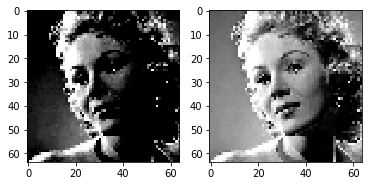

In [7]:
n = 17
fig = plt.subplot(1, 2, 1)
fig.imshow(loaded_images[n]);

fig = plt.subplot(1, 2, 2)
fig.imshow(((loaded_images[n]+1) * 127.5).astype(np.int16));
#
print("Gender:", genders[n])
print("Age:", ages[n])

Girls: [ 691. 3889. 2160. 1203.  765.  829.]
Boys: [  708. 10233.  5959.  4224.  3373.  4104.]


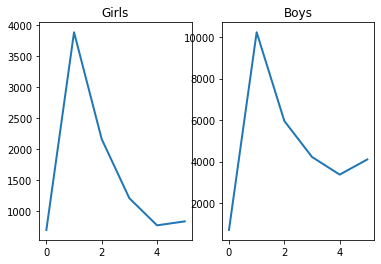

In [8]:
girls = genders == 0
boys = genders == 1
print("Girls:", np.sum(ages[girls], axis=0))
print("Boys:", np.sum(ages[boys], axis=0))

fig = plt.subplot(1, 2, 1)
fig.plot(np.sum(ages[girls], axis=0));
fig.set_title("Girls")

fig = plt.subplot(1, 2, 2)
fig.plot(np.sum(ages[boys], axis=0));
fig.set_title("Boys");

## Setup logging in tensorboard

In [9]:
timestamp = time.time()
tensorboard = TensorBoard(log_dir="logs/{}".format(timestamp))
tensorboard.set_model(generator)
tensorboard.set_model(discriminator)
os.mkdir("results/{}".format(timestamp))

## Train GAN

In [10]:
if LOAD_WEIGHTS:
    generator.load_weights("generator.h5")
    discriminator.load_weights("discriminator.h5")

In [11]:
# Implement label smoothing
real_labels = np.ones((batch_size, 1), dtype=np.float32) * 0.99
fake_labels = np.zeros((batch_size, 1), dtype=np.float32) + 0.01

In [ ]:
if TRAIN_GAN:
    for epoch in range(epochs):
        print("Epoch:{}".format(epoch))
    
        # History
        gen_losses = []
        dis_losses = []

        number_of_batches = int(len(loaded_images) / batch_size)
        print("Number of batches:", number_of_batches)
        for index in range(number_of_batches):
            
            # prepare batch
            images_batch = loaded_images[index * batch_size:(index + 1) * batch_size]
            age_batch = ages[index * batch_size:(index + 1) * batch_size]
            gender_batch = genders[index * batch_size:(index + 1) * batch_size]
            
            # create random noise vector
            z_noise = np.random.normal(0, 1, size=(batch_size, latend_dim))

            """
            Train the discriminator network
            """

            # Generate fake images
            initial_recon_images = generator.predict_on_batch([z_noise, age_batch, gender_batch])
            
            # train discriminator on the real and the fake
            d_loss_real = discriminator.train_on_batch([images_batch, age_batch, gender_batch], real_labels)
            d_loss_fake = discriminator.train_on_batch([initial_recon_images, age_batch, gender_batch], fake_labels)

            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            """
            Train the generator network
            """
            # generate random noise vectors
            z_noise2 = np.random.normal(0, 1, size=(batch_size, latend_dim))
            
            random_age = np.random.randint(0, 6, batch_size).reshape(-1, 1)
            random_age = to_categorical(random_age, 6)
            
            random_gender = np.random.randint(0,2,batch_size).reshape(-1, 1)

            # train the generator to generate real images from the noise
            g_loss = adversarial_model.train_on_batch([z_noise2, random_age, random_gender], [1] * batch_size)

            gen_losses.append(g_loss)
            dis_losses.append(d_loss)

            if index % print_frequenzy == 0:
                print("Batch:{}".format(index))
                print("d_loss:{}".format(d_loss))
                print("g_loss:{}".format(g_loss))
            
            """
            Generate images after every 1000 batch
            """
            if index % generate_image_frequenzy == 0:
                # Generate noise vector
                z_noise = np.random.normal(0, 1, size=(generation_size, latend_dim))
                
                random_age = np.random.randint(0, 6, generation_size).reshape(-1, 1)
                random_age = to_categorical(random_age, 6)
            
                random_gender = np.random.randint(0,2,generation_size).reshape(-1, 1)
                
                # Generate image from noise vector
                gen_images = generator.predict_on_batch([z_noise, random_age, random_gender])

                for i, img in enumerate(gen_images):
                    outputs.save_rgb_img(img, path="results/{}/img_{}_{}_{}.png".format(timestamp, epoch, index, i))
                
        """
        Generate images after every epoch
        """
        # Generate noise vector
        z_noise = np.random.normal(0, 1, size=(generation_size, latend_dim))

        random_age = np.random.randint(0, 6, generation_size).reshape(-1, 1)
        random_age = to_categorical(random_age, 6)

        random_gender = np.random.randint(0,2,generation_size).reshape(-1, 1)

        # Generate image from noise vector
        gen_images = generator.predict_on_batch([z_noise, random_age, random_gender])

        for i, img in enumerate(gen_images):
            outputs.save_rgb_img(img, path="results/{}/img_{}_{}_final.png".format(timestamp, epoch, i))
                
        # Write losses to Tensorboard
        write_log(tensorboard, 'g_loss', np.mean(gen_losses), epoch)
        write_log(tensorboard, 'd_loss', np.mean(dis_losses), epoch)
        
        
        # Save networks
        try:
            generator.save_weights("generator_{}.h5".format(epoch))
            discriminator.save_weights("discriminator_{}.h5".format(epoch))
        except Exception as e:
            print("Error:", e)

Epoch:0
Number of batches: 6356
Batch:0
d_loss:0.7007216215133667
g_loss:0.6871339678764343
Batch:100
d_loss:0.9418026804924011
g_loss:2.680758237838745
Batch:200
d_loss:0.13759396970272064
g_loss:3.980250120162964
Batch:300
d_loss:0.1288575828075409
g_loss:15.89920425415039
Batch:400
d_loss:0.07146573066711426
g_loss:3.7711589336395264
Batch:500
d_loss:0.15311548113822937
g_loss:7.6454949378967285
Batch:600
d_loss:0.08811143040657043
g_loss:3.484081506729126
Batch:700
d_loss:0.5905481576919556
g_loss:10.18173885345459
Batch:800
d_loss:0.2196078896522522
g_loss:6.336644649505615
Batch:900
d_loss:0.14839959144592285
g_loss:5.232731342315674
Batch:1000
d_loss:0.6831629276275635
g_loss:17.08957290649414
Batch:1100
d_loss:0.1436058133840561
g_loss:7.263296127319336
Batch:1200
d_loss:0.13816361129283905
g_loss:4.922811508178711
Batch:1300
d_loss:0.08126147091388702
g_loss:4.5863237380981445
Batch:1400
d_loss:0.06395812332630157
g_loss:3.227407693862915
Batch:1500
d_loss:0.0803619772195816
g

## Train Encoder

## Optimize latent